Brian Blaylock  
June 6, 2018  
[Webpage](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html)  

# Earth-Relative vs. Grid-Relative Winds
Appropriately rotating vector winds for the the High-Resolution Rapid Refresh Model (HRRR) on matplotlib Basemap.

---

## Difference between earth- and grid-relative winds

GRIB2 model U and V components are either _grid relative_ or _earth relative_. The vectors can be different depending on the map projection.

- **Grid Relative**: The U component points in the left-right direction relative to the model domain's grid and V points in the bottom-top direction.
- **Earth Relative**: The U component points in the east-west direction and V points in the north-south direction.

Raw model output will typically be _grid-relative_. You can check if a GRIB2 file is earth or grid relative like this:
    
    wgrib2 -vector_dir [file_name]

_Do I really need to convert the GRIB2 file from grid relative to earth relative?_ Yes, but the conversion is only necessary for vector quantities (i.e. U and V wind components) and for models on a rotated grid. Furthermore, when plotting vector quantities (wind barbs, quivers, or streamlines) on a map, you need to consider both the dataset's vector frame of reference and the map projection. 

The conversion from _grid-relative_ to _earth-relative_ is necessary becuase the _grid-relative_ wind direction for some map projections is not oriented north-south. The [wgrib2: -new_grid_winds](http://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/new_grid_winds.html) documentation states:

>For lat-lon, Mercator and Gaussian grids, the grid and earth relative directions are the same. For the Lambert conformal, polar stereographic and various rotated grids, the directions are different.

Since the CONUS HRRR is on a Lambert conformal projection and the Alaska HRRR is on a polar stereographic projection, it is important to convert the winds from _grid-_ to _earth-relative._ The two most-used variables that need the conversion are `UGRD` and `VGRD`.

You can use the `wgrib2` command-line utility to make the conversion. The conversion requires using the [`-new_grid`](http://www.cpc.ncep.noaa.gov/products/wesley/wgrib2/new_grid.html) option, which will be demonstrated in this notebook. 

----

FYI: The [formula](http://www2.mmm.ucar.edu/wrf/users/FAQ_files/Miscellaneous.html) to rotate the grid-relative winds to earth-relative is:

    u-earth = u-model*cosalpha - v-model*sinalpha
    v-earth = v-model*cosalpha + u-model*sinalpha
    
`cosalpha` and `sinalpha` are outputs of the WRF model and reprsent the "Local sine/cosine of map rotation", but are not directly available in the GRIB2 output, so this formulat isn't much help to us. It's best to use the `-new_grid` conversion tool built into `wgrib2`.

---
## Rotate vectors with matplotlib's Basemap
You should also be aware that you need to appropriatly rotate the vector quantities for a matplotlib Basemap object before applying `m.barbs` or `m.quiver`. You _don't_ have to rotate the vectors **if you are plotting the vectors on the same map projection as the model**. You _do_ have to rotate the vectors if you change the map projection from the original model grid.

Basemap's method `rotate_vector()` takes **_earth-relative_** vectors and rotates them appropriately for the map projection. According to the Basemap documentation [[1](https://matplotlib.org/basemap/api/basemap_api.html?highlight=rotate_vector#mpl_toolkits.basemap.Basemap.rotate_vector), [2](https://basemaptutorial.readthedocs.io/en/latest/utilities.html#rotate-vector)]:
> `rotate_vector(uin, vin, lons, lats, returnxy=False)`  
> The input vector field is defined in spherical coordinates (it has eastward and northward components) while the output vector field is rotated to map projection coordinates (relative to x and y). The magnitude of the vector is preserved.

Thus, before we can use the `rotate_vector()` method, the U and V components must be in _earth-relative_ coordinates.

---

##### Steps to plot HRRR model barbs or quiver on a Basemap:  
1. Convert U and V component from _grid-relative_ to _earth-relative_ with `wgrib2`
2. Load the data in python using `pygrib`
3. Rotate the vectors relative to the map projection with Basemap's `m.rotate_vector()` method, where `m` is the Basemap object.
4. Plot the rotated vectors using `m.barbs()` or `m.quiver()`
___


>Note: If you are not plotting wind barbs on a map (such as a time series or wind rose), there is no need to rotate the vectors beyond converting from _grid-relative_ to _earth-relative_. Then the figure will be interpreted as north being the top of the figure.

---

To get started, we need to import a few libraries...

In [1]:
%matplotlib inline
import pygrib
import os
import numpy as np
import urllib
import matplotlib.pyplot as plt

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_wx_calcs.wind import wind_uv_to_spd, wind_uv_to_dir
from BB_basemap.draw_maps import draw_CONUS_HRRR_map, draw_CONUS_cyl_map, draw_ALASKA_cyl_map

First, download a HRRR file from the [Pando HRRR archive](hrrr.chpc.utah.edu/).

In [2]:
URL = 'https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180425/hrrr.t00z.wrfsfcf00.grib2'
FILE = URL.split('/')[-1]
print 'File URL: %s' % URL
print 'File Name: %s' % FILE

File URL: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20180425/hrrr.t00z.wrfsfcf00.grib2
File Name: hrrr.t00z.wrfsfcf00.grib2


In [3]:
urllib.urlretrieve(URL, FILE)

('hrrr.t00z.wrfsfcf00.grib2', <httplib.HTTPMessage instance at 0x2ac4b6e9c0e0>)

Using pygrib, we can plot the data to see what it looks like. As you will see, the model is projected on a rotated grid. 

In [4]:
grbs = pygrib.open(FILE)

In [5]:
# Use wgrib2 to learn the grib message number for the variables.
# 59 and 60 are the 10-m U and V wind components
U, lat, lon = grbs[59].data()
V, lat, lon = grbs[60].data()

In [6]:
print np.shape(U)
grid_y, grid_x = np.shape(U)
X,Y = np.meshgrid(range(grid_x), range(grid_y))

(1059, 1799)


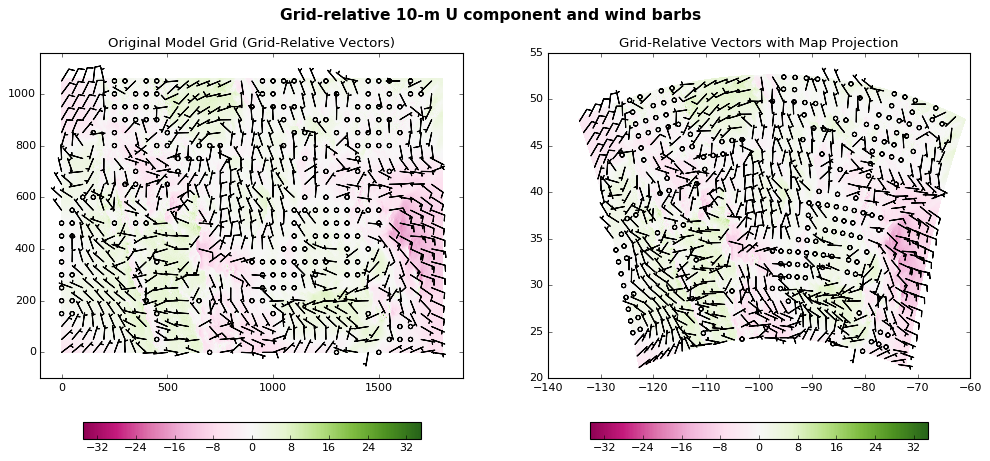

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,7])

thin = 50

plt.sca(ax1)
plt.pcolormesh(U, cmap='PiYG', vmax=35, vmin=-35)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax1.set_xlim([-100,np.shape(U)[1]+100])
ax1.set_ylim([-100,np.shape(U)[0]+100])
ax1.set_title('Original Model Grid (Grid-Relative Vectors)')
ax1.barbs(X[::thin,::thin], Y[::thin,::thin], U[::thin,::thin], V[::thin,::thin],
          color='k',
          length=5,
          label='Grid-Relative')

plt.sca(ax2)
plt.pcolormesh(lon, lat, U, cmap='PiYG', vmax=35, vmin=-35)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax2.set_title('Grid-Relative Vectors with Map Projection')
ax2.barbs(lon[::thin,::thin], lat[::thin,::thin], U[::thin,::thin], V[::thin,::thin],
          color='k',
          length=5,
          label='Grid-Relative')


plt.suptitle('Grid-relative 10-m U component and wind barbs', fontsize=14, fontweight='semibold')

Can you see the problem? The wind barbs in the left figure are correct becuase the vectors point from top-bottom and left-right. But, when the latitude and longitude of each point is considered, the vectors do not rotate with the map transformation. That is, the vectors on the left and right figures are identical even though the right figure is distorted to the map projection. Note that the map distortion has no impact on non-vector quantities, like temperature or pressure. Likewise, the map distortion has no influence on the wind magnitude, just the wind direction.

---

If you use the command `wgrib2 filename.grib2 -vector_dir` you will see the winds in the file are labeled `(grid)`. We need to convert the U and V component to earth-relative or `(N/S)`.

If you look at the `-new_grid` documentation, you will realize that in order to change the orientation of the winds to earth-relative, you need to  create a whole new file and define the new grid. This is not intuitive, becuase you have to specify what the new grid should be. _But we want the new grid to match the original grid._ To find the grid format for the existing file, there is a perl script available in the `-new_grid` documentation called [`grid_defn.pl`](http://ftp.cpc.ncep.noaa.gov/wd51we/wgrib2.scripts/grid_defn.pl) that we can use to print out the grid format information we need for the regriding. (If you or I feel ambitious, we would rewrite that perl script in Python, the true language).

I have already run this script for the downloaded HRRR file:

    perl grid_defn.pl hrrr.t00z.wrfsfcf00.grib2
>lambert:262.500000:38.500000:38.500000:38.500000 237.280472:1799:3000.000000 21.138123:1059:3000.000000

You can get that same information by using `wgrib2 -d 1 -grid hrrr.t00z.wrfsfcf00.grib2`

With that information, we can now complete the regridding function. **This is what you want to run in your terminal to regrid the CONUS HRRR grib2 file:**
    
    wgrib2 hrrr.t00z.wrfsfcf00.grib2 -new_grid_winds earth -new_grid lambert:262.500000:38.500000:38.500000:38.500000 237.280472:1799:3000.000000 21.138123:1059:3000.000000 hrrr.t00z.wrfsfcf00.grib2.regrid
    
After running that it will create a new HRRR file with the `.regrid` label on the end.

In [8]:
# Create the .regrid file
HRRR_grid = 'lambert:262.500000:38.500000:38.500000:38.500000 237.280472:1799:3000.000000 21.138123:1059:3000.000000'

os.system('wgrib2 %s -new_grid_winds earth -new_grid %s %s' % (FILE, HRRR_grid, FILE+'.earth'))

0

---

Now load the new regidded file so we can draw some comparisions.

In [9]:
grbs_regrid = pygrib.open(FILE+'.earth')

In [10]:
# Use wgrib2 to learn the grib message number for the variables.
# 59 and 60 are the 10-m U and V wind components
U_rg, lat_rg, lon_rg = grbs_regrid[59].data()
V_rg, lat_rg, lon_rg = grbs_regrid[60].data()

In [11]:
print np.shape(U_rg)
grid_y_rg, grid_x_rg = np.shape(U_rg)
X_rg, Y_rg = np.meshgrid(range(grid_x_rg), range(grid_y_rg))

(1059, 1799)


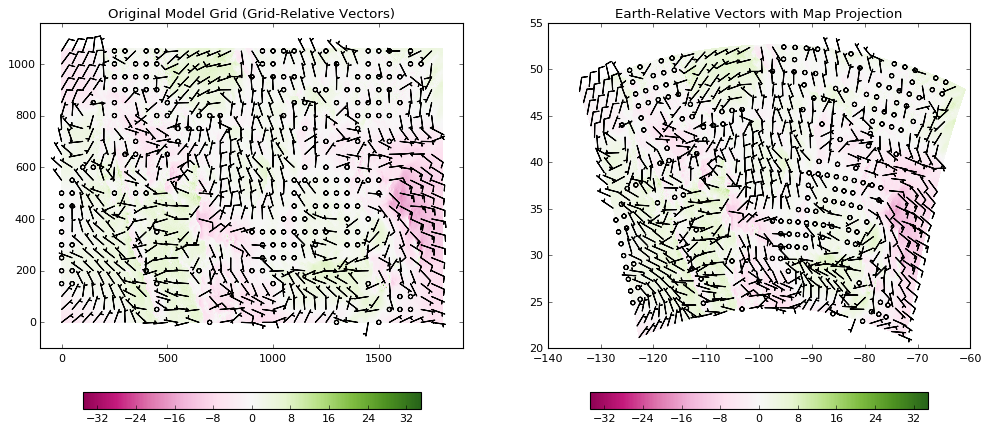

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,7])

thin = 50

plt.sca(ax1)
plt.pcolormesh(U, cmap='PiYG', vmax=35, vmin=-35)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax1.set_xlim([-100,np.shape(U)[1]+100])
ax1.set_ylim([-100,np.shape(U)[0]+100])
ax1.set_title('Original Model Grid (Grid-Relative Vectors)')
ax1.barbs(X[::thin,::thin], Y[::thin,::thin], U[::thin,::thin], V[::thin,::thin],
          color='k',
          length=5,
          label='Grid-Relative')

plt.sca(ax2)
plt.pcolormesh(lon_rg, lat_rg, U_rg, cmap='PiYG', vmax=35, vmin=-35)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax2.set_title('Earth-Relative Vectors with Map Projection')
ax2.barbs(lon_rg[::thin,::thin], lat_rg[::thin,::thin], U_rg[::thin,::thin], V_rg[::thin,::thin],
          color='k',
          length=5,
          label='Earth-Relative')

Notice that the vectors between the two figures are different. Both figures have the correct wind vectors for the given frame of reference. The left figure shows the model grid with _grid-relative_ wind vectors, but provides no information about the map. The right figure shows the data distorted to the map projection, and the vectors are rotated appropriately for the map projection where north is the top of the figure. Also note that the vectors along the vertical axis in the center of the figure are not rotated becuase there is no map distortion along that axis. The biggest map distortions occur on the east-most and west-most edges and that is where the vectors are turned the most.

---

The next figure illustrates that **the latitude and longitude values between the raw file and regridded file are the same**.

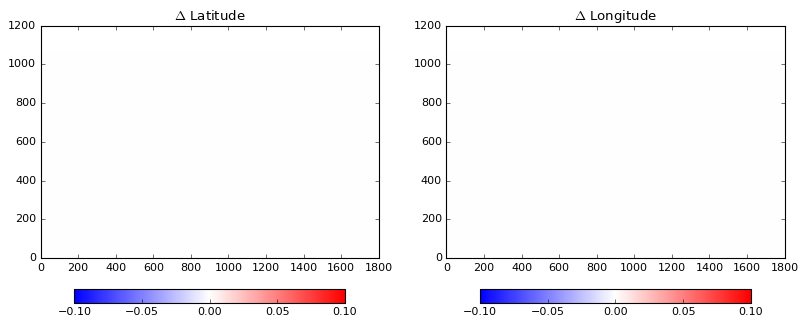

In [13]:
diff_lon = lon_rg-lon
diff_lat = lat_rg-lat

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,5])
plt.sca(ax1)
plt.pcolormesh(diff_lat, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title(r'$\Delta$ Latitude')

plt.sca(ax2)
plt.pcolormesh(diff_lon, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title(r'$\Delta$ Longitude')

In [14]:
# Show that the difference is zero
print diff_lon.max(), diff_lon.min()
print diff_lat.max(), diff_lat.min()

0.0 0.0
0.0 0.0


---

There are differences between the U and V wind component fields between the _grid-relative_ and _earth-relative_ vectors. Becuase we know the latitude and longitude are not differnt, we can plot their differences on the model's latitude and longitude grid.

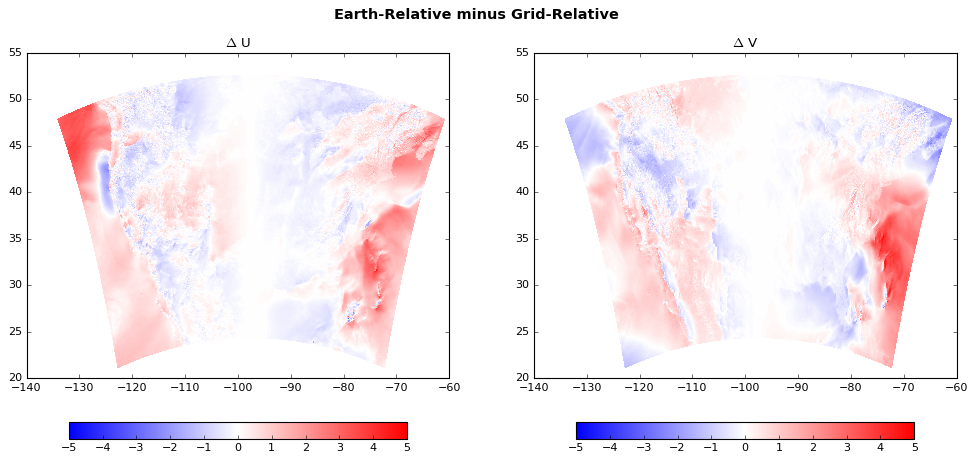

In [15]:
diff_U = U_rg-U
diff_V = V_rg-V

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,7])
plt.sca(ax1)
plt.pcolormesh(lon, lat, diff_U, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title(r'$\Delta$ U')

plt.sca(ax2)
plt.pcolormesh(lon, lat, diff_V, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title(r'$\Delta$ V')

plt.suptitle('Earth-Relative minus Grid-Relative', fontsize=13, fontweight='semibold')

Again, notice that there is no change along the vertical axis in the center of the map where there is not map distorition.

You might expect that since there are differences in U and V that the wind speeds may also be different, but the magnitude is preserved when you transform the winds to _earth-relative_. Thus, the wind speed magnitude differences are very small between the _grid-relative_ and _earth-relative_ files. The largest difference in wind speed is less than a one-tenth of a m s<sup>-1</sup>.

Max difference 0.0549005191255 m/s
Min difference -0.0714914475896 m/s


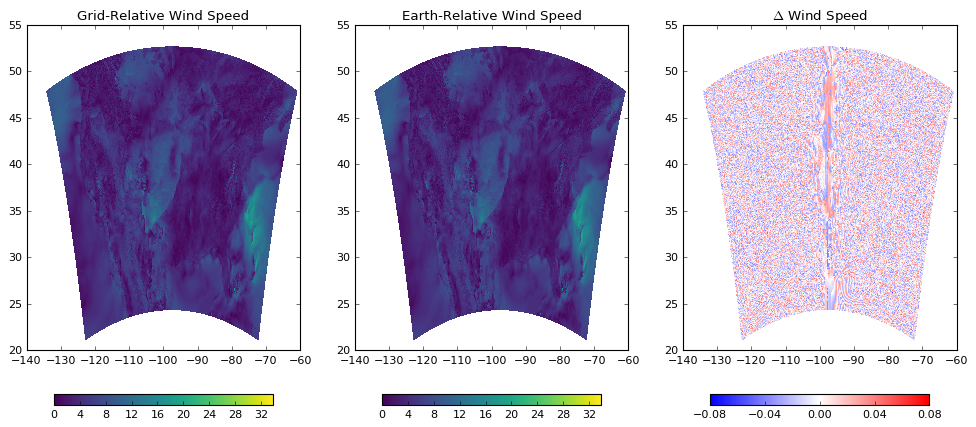

In [16]:
spd = wind_uv_to_spd(U,V)
spd_rg = wind_uv_to_spd(U_rg,V_rg)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15,7])
plt.sca(ax1)
plt.pcolormesh(lon, lat, spd, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Grid-Relative Wind Speed')

plt.sca(ax2)
plt.pcolormesh(lon, lat, spd_rg, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Earth-Relative Wind Speed')

plt.sca(ax3)
plt.pcolormesh(lon, lat, spd_rg-spd, cmap='bwr', vmin=-.08, vmax=.08)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks(np.arange(-.08,.09,.04))
plt.title(r'$\Delta$ Wind Speed')

print "Max difference %s m/s" % np.max(spd_rg-spd)
print "Min difference %s m/s" % np.min(spd_rg-spd)

---

**The biggest reason why we need _earth-relative_ winds is so we can accuratly plot wind direction on a Basemap**. This becomes evident when we plot _grid-relative_ and _earth-relative_ wind barbs on a Basemap. Remember, we need to rotate the _earth-relative_ wind vectors by the map proejctions with the method `rotate_vector()`.

You will see again that **the largest error in wind direction is at the peripheries of the model domain**.

In [17]:
# These two functions I imported make the Basemap object. 
#   The first is a map with the same projection as the HRRR model.
#   The second is a cylindrical projection of the CONUS.
m = draw_CONUS_HRRR_map()
m2 = draw_CONUS_cyl_map()

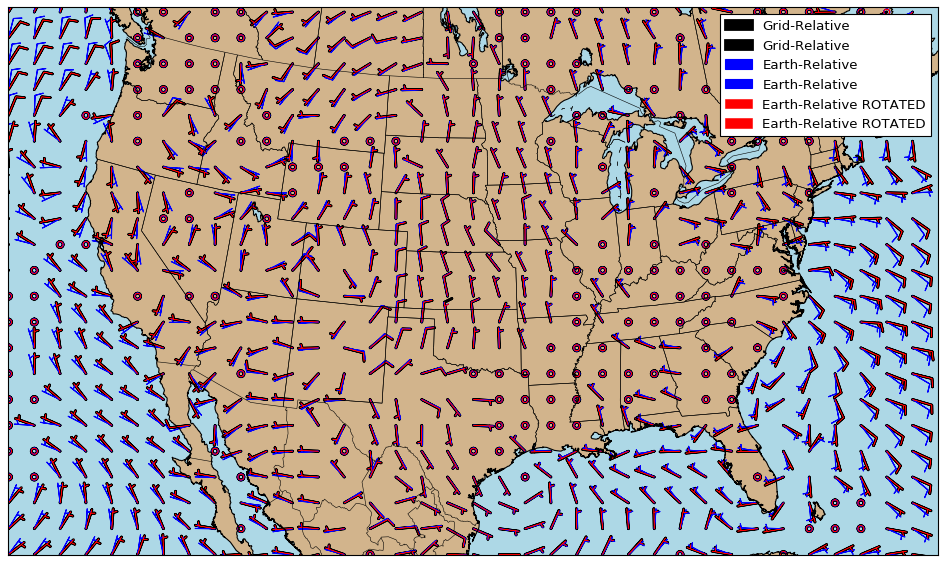

In [18]:
plt.figure(figsize=[15,10])
m.drawcountries()
m.drawstates()
m.drawcoastlines()
m.fillcontinents(color='tan',lake_color='lightblue', zorder=0)
m.drawmapboundary(fill_color='lightblue')


thin = 50

# Plot the Grid-Relative Winds
m.barbs(lon[::thin,::thin], lat[::thin,::thin], U[::thin,::thin], V[::thin,::thin],
        color='k',
        length=6,
        linewidth=2.5,
        latlon=True,
        label='Grid-Relative')

# Plot the Earth-Relative Winds
m.barbs(lon_rg[::thin,::thin], lat_rg[::thin,::thin], U_rg[::thin,::thin], V_rg[::thin,::thin],
        color='b',
        length=6,
        latlon=True,
        label='Earth-Relative')

# Plot the Earth-Relative Winds ROTATED TO MAP PROJECTION. Note: rotating has no effect on the latlon grid.
U_rg_rot, V_rg_rot = m.rotate_vector(U_rg, V_rg, lon_rg, lat_rg) 
m.barbs(lon_rg[::thin,::thin], lat_rg[::thin,::thin], U_rg_rot[::thin,::thin], V_rg_rot[::thin,::thin],
        color='r',
        length=6,
        linewidth=.5,
        latlon=True,
        label='Earth-Relative ROTATED')


plt.legend()

The **_grid-relative_ vectors are black**, **<span style="color:blue">_earth-relative_ vectors are blue</span>**, and **<span style="color:red">ROTATED _earth-relative_ vectors are red</span>**

The <span style="color:red">_earth-relative_ ROTATED vectors</span> are the correct vectors. Notice that the **_grid-relative_** and <span style="color:red">**_rotated_**</span> winds are identical (I made the black barbs thicker so you can see them under the red barbs).This is becuase the _grid-relative_ winds are plotted on the same map projection the model data is on. The <span style="color:blue">**_earth-relative_**</span> vectors are wrong on this figure because they have not been rotated/distorted with the map.

> ### You can only use the _grid-relative_ vectors **_if_** the Basemap has the same projection as the original model output.

> ### If the Basemap projection is different from the original model outpt, then you must rotate the _earth-relative_ vectors for the map projection.

Below illustrates this point again by plotting the data on a cylindrical map.

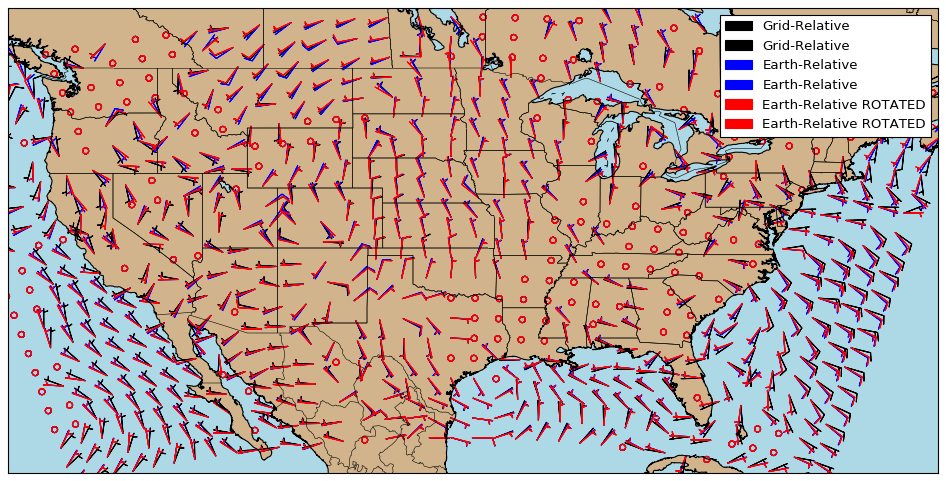

In [19]:
plt.figure(figsize=[15,10])
m2.drawcountries()
m2.drawstates()
m2.drawcoastlines()
m2.fillcontinents(color='tan',lake_color='lightblue', zorder=0)
m2.drawmapboundary(fill_color='lightblue')

thin = 50

# Plot the Grid-Relative Winds
m2.barbs(lon[::thin,::thin], lat[::thin,::thin], U[::thin,::thin], V[::thin,::thin],
        color='k',
        length=6,
        latlon=True,
        label='Grid-Relative')

# Plot the Earth-Relative Winds
m2.barbs(lon_rg[::thin,::thin], lat_rg[::thin,::thin], U_rg[::thin,::thin], V_rg[::thin,::thin],
        color='b',
        length=6,
        latlon=True,
        label='Earth-Relative')

# Plot the Earth-Relative Winds ROTATED TO MAP PROJECTION. Note: rotating has no effect on the latlon grid.
U2_rg_rot, V2_rg_rot = m2.rotate_vector(U_rg, V_rg, lon_rg, lat_rg) 
m2.barbs(lon_rg[::thin,::thin], lat_rg[::thin,::thin], U2_rg_rot[::thin,::thin], V2_rg_rot[::thin,::thin],
        color='r',
        length=6,
        latlon=True,
        label='Earth-Relative ROTATED')

plt.legend()

Only the <span style="color:red">**rotated**</span> vectors are correct in this map. The **_grid-relative_** winds are not correct in this figure because we have changed the map projection of the data. Notice that the largest error is on the peripheries again. There are small but suble differences in the <span style="color:blue">**_earth-relative_**</span> and the <span style="color:red">**rotated**</span> vectors after rotating the _earth-relative_ winds related to the map projection. The correct solution is the red, rotated vectors.

## HRRR-Alaska
The Alaska HRRR grid is just weird. It is on a polar stereographic grid and requires a little extra work. But converting the winds to earth relative is much more important in Alaska than in the CONUS due to the extensive map distortion.

The grid definition as described by the `grid_defn.pl` script is:
>nps:225.000000:60.000000 185.117126:1299:3000.000000 41.612949:919:3000.000000

Taylor McCorkle used this regrid option instead to trim down the data and put it on a regular lat-lon domain (this is for the original HRRR-Alaska domain before the upgrade):
> latlon -175.75:1800:0.0269 46.863:1000:0.0269

I am going to use the first method, not Taylor's.

In [20]:
AK_URL = 'https://pando-rgw01.chpc.utah.edu/hrrrak/sfc/20180425/hrrrak.t00z.wrfsfcf00.grib2'
AK_FILE = AK_URL.split('/')[-1]
print 'File URL: %s' % AK_URL
print 'File Name: %s' % AK_FILE

File URL: https://pando-rgw01.chpc.utah.edu/hrrrak/sfc/20180425/hrrrak.t00z.wrfsfcf00.grib2
File Name: hrrrak.t00z.wrfsfcf00.grib2


In [21]:
urllib.urlretrieve(AK_URL, AK_FILE)

('hrrrak.t00z.wrfsfcf00.grib2',
 <httplib.HTTPMessage instance at 0x2ac4b94545a8>)

Now make a regridded version with earth-relative winds

In [22]:
ALASKA_grid = 'nps:225.000000:60.000000 185.117126:1299:3000.000000 41.612949:919:3000.000000'

os.system('wgrib2 %s -new_grid_winds earth -new_grid %s %s' % (AK_FILE, ALASKA_grid, AK_FILE+'.earth'))

0

Using pygrib, we can plot the data to see what it looks like. As you will see, the model is projected on a rotated grid. 

In [23]:
# Grid Relative
AK_grbs = pygrib.open(AK_FILE)
AK_U, AK_lat, AK_lon = AK_grbs[75].data()
AK_V, AK_lat, AK_lon = AK_grbs[76].data()

# Earth Relative
AK_grbs_rg = pygrib.open(AK_FILE+'.earth')
AK_U_rg, AK_lat_rg, AK_lon_rg = AK_grbs_rg[75].data()
AK_V_rg, AK_lat_rg, AK_lon_rg = AK_grbs_rg[76].data()

We need to correct the funky issue with the longitude. Here is the secret sauce:

In [24]:
#Funky things going on with longitude. This is the fix:
AK_lon[AK_lon>0] -= 360
AK_lon_rg[AK_lon_rg>0] -= 360

Plot the raw Alaska grid and the map projection

In [25]:
print np.shape(AK_U)
AK_grid_y, AK_grid_x = np.shape(AK_U)
AK_X, AK_Y = np.meshgrid(range(AK_grid_x), range(AK_grid_y))

(919, 1299)


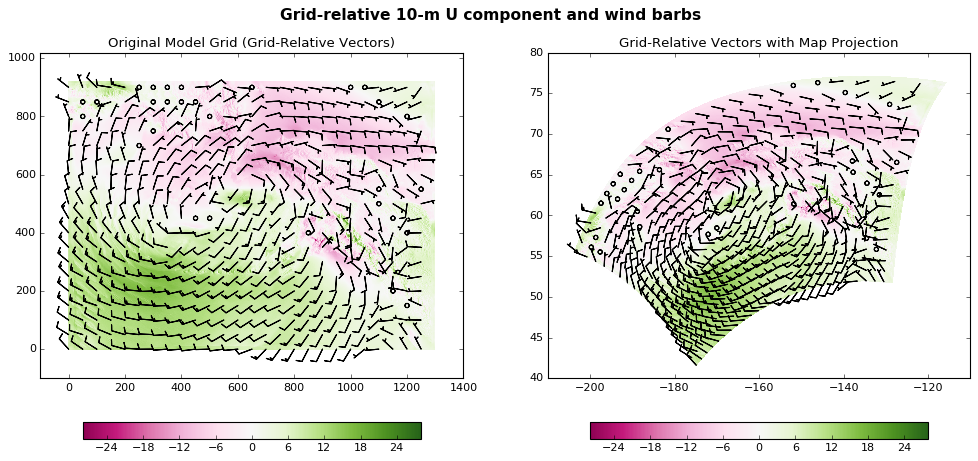

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,7])

thin = 50

plt.sca(ax1)
plt.pcolormesh(AK_U, cmap='PiYG', vmax=28, vmin=-28)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax1.set_xlim([-100,np.shape(AK_U)[1]+100])
ax1.set_ylim([-100,np.shape(AK_U)[0]+100])
ax1.set_title('Original Model Grid (Grid-Relative Vectors)')
ax1.barbs(AK_X[::thin,::thin], AK_Y[::thin,::thin], AK_U[::thin,::thin], AK_V[::thin,::thin],
          color='k',
          length=5,
          label='Grid-Relative')

plt.sca(ax2)
plt.pcolormesh(AK_lon, AK_lat, AK_U, cmap='PiYG', vmax=28, vmin=-28)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax2.set_title('Grid-Relative Vectors with Map Projection')
ax2.barbs(AK_lon[::thin,::thin], AK_lat[::thin,::thin], AK_U[::thin,::thin], AK_V[::thin,::thin],
          color='k',
          length=5,
          label='Grid-Relative')


plt.suptitle('Grid-relative 10-m U component and wind barbs', fontsize=14, fontweight='semibold')

Just as before, the vectors on the left are correct relative to the grid, but the vectors on the right are wrong because the data has been distorted by the map projection and the vectores have not been rotated.

---

Below compares the grid-relative and earth-relative winds

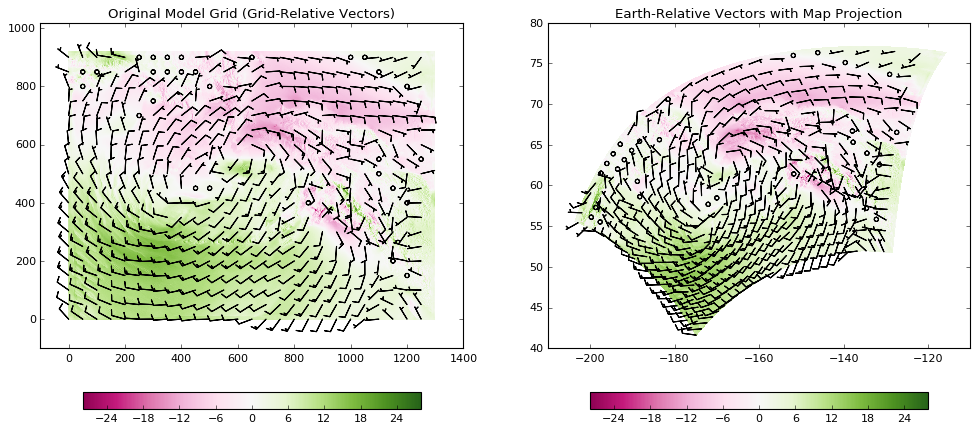

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,7])

thin = 50

plt.sca(ax1)
plt.pcolormesh(AK_U, cmap='PiYG', vmax=28, vmin=-28)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax1.set_xlim([-100,np.shape(AK_U)[1]+100])
ax1.set_ylim([-100,np.shape(AK_U)[0]+100])
ax1.set_title('Original Model Grid (Grid-Relative Vectors)')
ax1.barbs(AK_X[::thin,::thin], AK_Y[::thin,::thin], AK_U[::thin,::thin], AK_V[::thin,::thin],
          color='k',
          length=5,
          label='Grid-Relative')

plt.sca(ax2)
plt.pcolormesh(AK_lon_rg, AK_lat_rg, AK_U_rg, cmap='PiYG', vmax=28, vmin=-28)
plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
ax2.set_title('Earth-Relative Vectors with Map Projection')
ax2.barbs(AK_lon_rg[::thin,::thin], AK_lat_rg[::thin,::thin], AK_U_rg[::thin,::thin], AK_V_rg[::thin,::thin],
          color='k',
          length=5,
          label='Earth-Relative')

Both the above plots are correct according to their frame of reference. The left is the grid-relative vectors plotted on the grid. The right is the earth-relative vectors plotted on the map projection where north is the top of the plot.

Below shows again that there is no difference between the latitude and longitude in the original and regridded files.

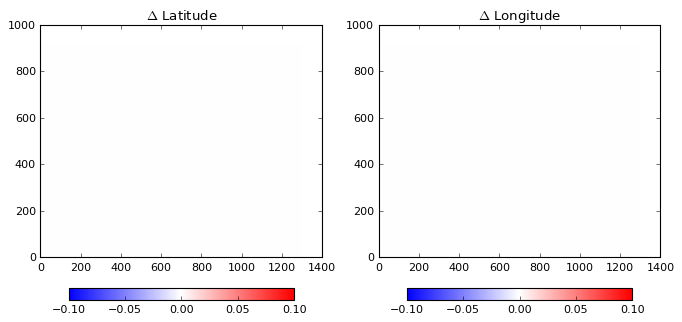

In [28]:
AK_diff_lon = AK_lon_rg-AK_lon
AK_diff_lat = AK_lat_rg-AK_lat

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[10,5])
plt.sca(ax1)
plt.pcolormesh(AK_diff_lat, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title(r'$\Delta$ Latitude')

plt.sca(ax2)
plt.pcolormesh(AK_diff_lon, cmap='bwr')
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks([-.1,-.05,0,.05,.1])
plt.title(r'$\Delta$ Longitude')

And just as we expected, there are differences in the U and V field

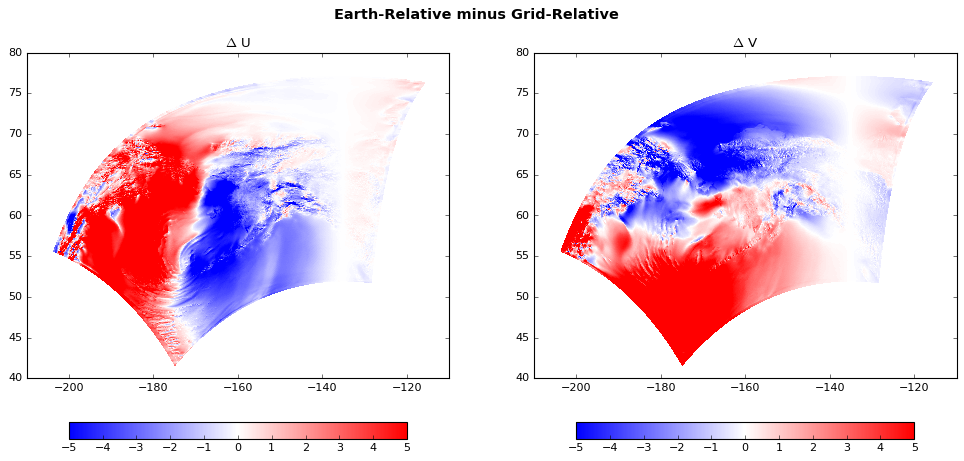

In [29]:
AK_diff_U = AK_U_rg-AK_U
AK_diff_V = AK_V_rg-AK_V

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,7])
plt.sca(ax1)
plt.pcolormesh(AK_lon, AK_lat, AK_diff_U, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title(r'$\Delta$ U')

plt.sca(ax2)
plt.pcolormesh(AK_lon, AK_lat, AK_diff_V, cmap='bwr', vmax=5, vmin=-5)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title(r'$\Delta$ V')

plt.suptitle('Earth-Relative minus Grid-Relative', fontsize=13, fontweight='semibold')

But minor differences in the wind speed

Max difference 0.0646050381642
Min difference -0.0679369483132


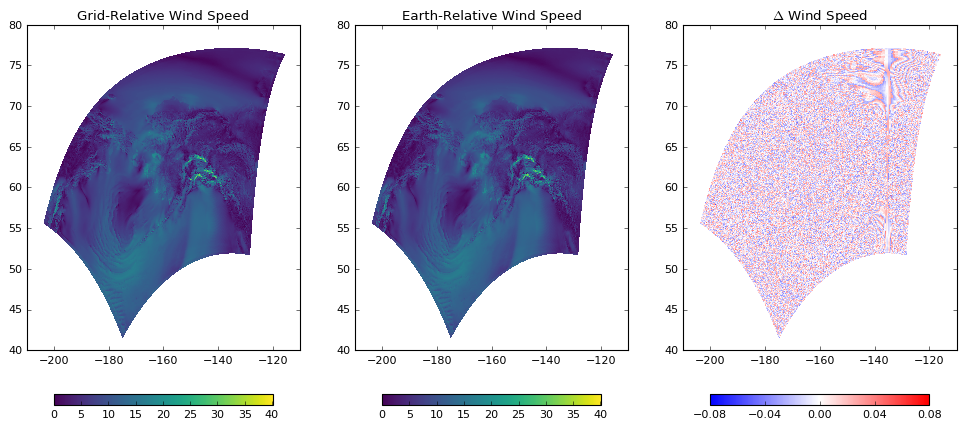

In [30]:
AK_spd = wind_uv_to_spd(AK_U,AK_V)
AK_spd_rg = wind_uv_to_spd(AK_U_rg, AK_V_rg)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15,7])
plt.sca(ax1)
plt.pcolormesh(AK_lon, AK_lat, AK_spd, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Grid-Relative Wind Speed')

plt.sca(ax2)
plt.pcolormesh(AK_lon, AK_lat, AK_spd_rg, cmap='viridis', vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
plt.title('Earth-Relative Wind Speed')

plt.sca(ax3)
plt.pcolormesh(AK_lon, AK_lat, AK_spd_rg-AK_spd, cmap='bwr', vmin=-.08, vmax=.08)
cb = plt.colorbar(orientation='horizontal', pad=.1, shrink=.8)
cb.set_ticks(np.arange(-.08,.09,.04))
plt.title(r'$\Delta$ Wind Speed')

print "Max difference", np.max(AK_spd_rg-AK_spd)
print "Min difference", np.min(AK_spd_rg-AK_spd)

Now draw the wind vectors to visualize the difference in wind speed

In [31]:
m3 = draw_ALASKA_cyl_map()

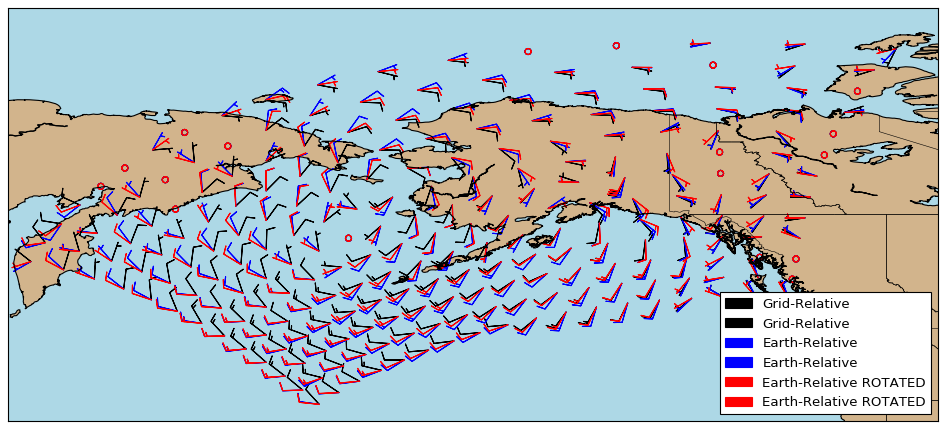

In [32]:
plt.figure(figsize=[15,10])

m3.drawcountries()
m3.drawstates()
m3.drawcoastlines()
m3.fillcontinents(color='tan',lake_color='lightblue', zorder=0)
m3.drawmapboundary(fill_color='lightblue')

thin = 75

m3.barbs(AK_lon[::thin,::thin], AK_lat[::thin,::thin], AK_U[::thin,::thin], AK_V[::thin,::thin],
        color='k',
        length=6,
        latlon=True,
        label='Grid-Relative')
m3.barbs(AK_lon_rg[::thin,::thin], AK_lat_rg[::thin,::thin], AK_U_rg[::thin,::thin], AK_V_rg[::thin,::thin],
        color='b',
        length=6,
        latlon=True,
        label='Earth-Relative')

# Plot the Earth-Relative Winds ROTATED TO MAP PROJECTION. Note: rotating has no effect on the latlon grid.
AK_U3_rg_rot, AK_V3_rg_rot = m3.rotate_vector(AK_U_rg, AK_V_rg, AK_lon_rg, AK_lat_rg) 
m3.barbs(AK_lon_rg[::thin,::thin], AK_lat_rg[::thin,::thin], AK_U3_rg_rot[::thin,::thin], AK_V3_rg_rot[::thin,::thin],
         color='r',
         length=6,
         latlon=True,
         label='Earth-Relative ROTATED')

plt.legend(loc=4)

Only the <span style="color:red">**rotated**</span> vectors are correct in this map. The **_grid-relative_** winds are not correct in this figure because we have changed the map projection of the data. There are small but suble differences in the <span style="color:blue">**_earth-relative_**</span> and the <span style="color:red">**rotated**</span> vectors after rotating the _earth-relative_ winds to the map projection distortions.